# Testing decision tree decision path to compute infimum under $\nu$

In [1]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn import tree
import matplotlib.pyplot as plt

from CP2LFI.scores import Scores, LambdaScore, WaldoScore, BFFScore
from CP2LFI.loforest import ConformalLoforest
from clover import LocartSplit

# importing functions to adapt estimated cutoffs
from CP2LFI.nuissance import TRUST_nuisance_cutoffs, TRUST_plus_nuisance_cutoff

import torch
from CP2LFI.utils import fit_post_model
from torch.distributions.uniform import Uniform
from torch.distributions.poisson import Poisson
import itertools
from tqdm import tqdm

In [2]:
# Simulate data using sklearn function
X_train, y_train = make_regression(n_samples=50, n_features=3, random_state=42)

# Create a decision tree regressor object
regressor = DecisionTreeRegressor(max_leaf_nodes=5, random_state=0)

# Fit the regressor to the training data
regressor.fit(X_train, y_train)

# Predict the target variable for the test data
X_test = np.array([[2, 3, 4], [5, 6, 7]])
y_pred = regressor.predict(X_test)

x[0] is our parameter os interest and x[1] and x[2] are nuissance:

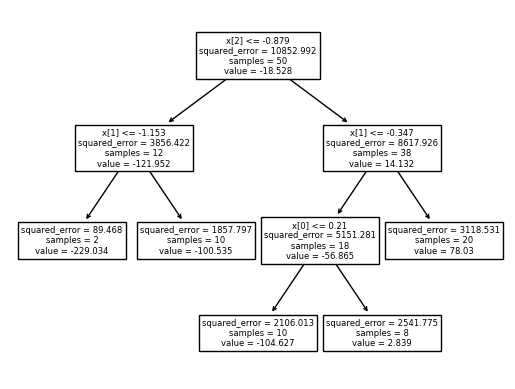

In [3]:
tree.plot_tree(regressor)
plt.show()

Exploring tree structure:

In [4]:
n_nodes = regressor.tree_.node_count
children_left = regressor.tree_.children_left
children_right = regressor.tree_.children_right
feature = regressor.tree_.feature
threshold = regressor.tree_.threshold
values = regressor.tree_.value

In [5]:
children_left

array([ 1,  7,  3,  5, -1, -1, -1, -1, -1], dtype=int64)

In [6]:
children_right

array([ 2,  8,  4,  6, -1, -1, -1, -1, -1], dtype=int64)

In [7]:
feature

array([ 2,  1,  1,  0, -2, -2, -2, -2, -2], dtype=int64)

In [8]:
threshold

array([-0.87932089, -1.1526942 , -0.34739607,  0.21025595, -2.        ,
       -2.        , -2.        , -2.        , -2.        ])

In [9]:
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)

while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    node_depth[node_id] = depth

    # If the left and right child of a node is not the same we have a split
    # node
    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))
    else:
        is_leaves[node_id] = True

In [10]:
regressor.apply(X_test)

array([4, 4])

Exploring tree in each level:

In [11]:
print(
    "The binary tree structure has {n} nodes and has "
    "the following tree structure:\n".format(n=n_nodes)
)
for i in range(n_nodes):
    if is_leaves[i]:
        print(
            "{space}node={node} is a leaf node with value={value}.".format(
                space=node_depth[i] * "\t", node=i, value=values[i]
            )
        )
    else:
        print(
            "{space}node={node} is a split node with value={value}: "
            "go to node {left} if X[:, {feature}] <= {threshold} "
            "else to node {right}.".format(
                space=node_depth[i] * "\t",
                node=i,
                left=children_left[i],
                feature=feature[i],
                threshold=threshold[i],
                right=children_right[i],
                value=values[i],
            )
        )

The binary tree structure has 9 nodes and has the following tree structure:

node=0 is a split node with value=[[-18.52785519]]: go to node 1 if X[:, 2] <= -0.87932088971138 else to node 2.
	node=1 is a split node with value=[[-121.95151352]]: go to node 7 if X[:, 1] <= -1.152694195508957 else to node 8.
	node=2 is a split node with value=[[14.13224745]]: go to node 3 if X[:, 1] <= -0.3473960682749748 else to node 4.
		node=3 is a split node with value=[[-56.86472587]]: go to node 5 if X[:, 0] <= 0.2102559469640255 else to node 6.
		node=4 is a leaf node with value=[[78.02952343]].
			node=5 is a leaf node with value=[[-104.62743522]].
			node=6 is a leaf node with value=[[2.83866081]].
		node=7 is a leaf node with value=[[-229.03435438]].
		node=8 is a leaf node with value=[[-100.53494535]].


## Strategy to obtain nuissance-free cutoff:

We can obtain nuissance-free cutoff through minimizing cutoff over all possible threshold values for the nuissance parameter $\nu$. Testing this approach in a simple nuissance example:

### Poisson model with two parameters, one nuisance:

In [12]:
# nu parameter space and prior: (0, 1.5)
# mu parameter space and prior: (0, 5)
# hyperparameters fixed: s = 15, b = 70, tau = 1 (same as the LF2I paper)
def prior(n):
    m = Uniform(torch.tensor([0.0, 0.0]), torch.tensor([1.5, 5.0]))
    return m.sample(n)

def simulator(theta, s = 15, b = 70, tau = 1):
    b_par = theta[:,0]*b*tau
    s_par = theta[:,0]*b + theta[:, 1]*s
    par = torch.stack((b_par, s_par), -1).float()
    m = Poisson(par)
    return m.sample()

fitting posterior estimator only on $\mu$:

Fitting normalizing flows posterior estimator:  18%|█▊        | 366/2000 [03:13<14:22,  1.90it/s]

Early stopping at epoch 366
a


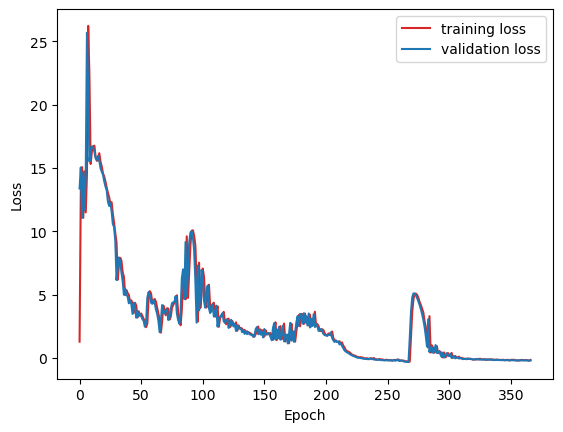

In [13]:
nflow_poisson_model = fit_post_model(
    simulator, 
    prior, 
    B_model = 20000, 
    n = 5, 
    seed = 125,
    nuisance_idx = 0, 
    split_seed = 45,
    patience = 100,
    n_flows = 6,
    poisson = True)

Fitting waldo score and setting $B$ and $n$ to fit our methods:

In [14]:
bff_score = BFFScore(nflow_poisson_model, is_fitted = True)
bff_score.fit()
B = 10000
n  = 5

Creating samples to train both TRUST and TRUST++ with majority votes:

In [15]:
torch.manual_seed(125)
torch.cuda.manual_seed(125)

print("Sampling from the parameter prior:")
thetas_sim = prior((B, ))

if thetas_sim.ndim == 1:
    model_thetas = thetas_sim.reshape(-1, 1)
else:
    model_thetas = thetas_sim

repeated_thetas = thetas_sim.repeat_interleave(repeats=n, dim=0)
X_net = simulator(repeated_thetas)
X_dim = X_net.shape[1]
X_net = X_net.reshape(B, n * X_dim)

print("Obtaining statistics sample: ")
model_lambdas = bff_score.compute_nuissance(
    model_thetas.numpy(), X_net.numpy(), nuissance_idx = 0, disable_tqdm=False, posterior_marginalized = True,
    )

print("Fitting our methods: ")
print("Fitting TRUST ")
trust_object = LocartSplit(
        LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
    )
trust_quantiles = trust_object.calib(
    model_thetas.numpy(), model_lambdas, min_samples_leaf=300
)

# loforest quantiles
print("Fitting TRUST++")
trust_plus_object = ConformalLoforest(
    LambdaScore, None, alpha=0.05, is_fitted=True, split_calib=False
)
trust_plus_object.calibrate(
    model_thetas.numpy(),
    model_lambdas,
    min_samples_leaf=300,
    n_estimators=200,
    K=100,
)

Sampling from the parameter prior:
Obtaining statistics sample: 
Fitting our methods: 
Fitting TRUST 
Fitting TRUST++


Testing implementation of nuisance function:

In [16]:
def TRUST_nuisance_cutoffs(
        trust_obj, 
        nuissance_idx,
        par_values,
        trust_quantiles,
        eps = 0.05
        ):
    # returning all thresholds
    feature_array = np.array(trust_obj.cart.tree_.feature)
    threshold_array = np.array(trust_obj.cart.tree_.threshold)

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])


    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)

        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in par_values:
            par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
            new_par = np.column_stack((par_array, nuis_values))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            idxs = trust_obj.cart.apply(new_par)
            list_locart_quantiles = np.array([trust_quantiles[idx] for idx in idxs])

            # returning minimal value
            cutoff_nuis[i] = np.max(list_locart_quantiles)
            i += 1
    else:
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        # TODO obtaining all combinations using itertools
        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)
    
    return cutoff_nuis

def TRUST_plus_nuisance_cutoff(
        trust_plus_obj,
        nuissance_idx,
        par_values,
        K = 100,
        eps = 0.05,
        ):
    threshold_list = []
    feature_list = []
    # returning all thresholds for each tree
    for tree in trust_plus_obj.RF.estimators_:
        feature_array = np.array(tree.tree_.feature)
        threshold_array = np.array(tree.tree_.threshold)

        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        feature_nuis = feature_array[idxs]

        threshold_list.extend(list(thres))
        feature_list.extend(list(feature_nuis))

    # cutoff array
    cutoff_nuis = np.zeros(par_values.shape[0])

    # selecting threshold_array with feature array equal to nuissance idx
    if isinstance(nuissance_idx, int):
        thres = np.array(threshold_list)
        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)

        # returning all index
        size = par_values.shape[1] + 1
        # idx list
        idx_array = np.arange(0, size)
        par_idx = idx_array[np.where(idx_array != nuissance_idx)]
        par_reorder = np.concatenate((par_idx, nuissance_idx), axis = None)

        i = 0
        for par in tqdm(par_values, desc = "Computing nuisance cutoffs for each parameter value"):
            par_array = np.tile(par, reps = (nuis_values.shape[0], 1))
            new_par = np.column_stack((par_array, nuis_values))

            # reordering columns
            new_par = new_par[:, par_reorder]

            # computing cutoffs for new par
            cutoff_vector = trust_plus_obj.compute_cutoffs(new_par, K = K)

            # returning minimal value
            cutoff_nuis[i] = np.max(cutoff_vector)
            i += 1
    else:
        idxs = np.where(feature_array == nuissance_idx)
        thres = threshold_array[idxs]
        # TODO obtaining all combinations using itertools
        nuis_values = np.concatenate((thres - eps, thres + eps), axis = None)
    
    return cutoff_nuis

In [54]:
mu_space = np.linspace(0.1, 4.9, 75)

In [55]:
nu_space = np.linspace(0.1, 1.49, 75)
mu_space = np.linspace(0.1, 4.9, 75)

# returning all combinations for fitting nuissance cutoffs
valid_thetas = np.c_[list(itertools.product(nu_space, mu_space))]

# returning meshgrid for plotting
nu_v, mu_v = np.meshgrid(nu_space, mu_space)

# obtaining cutoffs for each mu
cutoff_mu_TRUST = TRUST_nuisance_cutoffs(
    trust_object, 
    nuissance_idx = 0, 
    par_values = mu_space.reshape(-1, 1), 
    trust_quantiles = trust_quantiles, 
    eps = 0.05,
    )

cutoff_mu_TRUST_plus = TRUST_plus_nuisance_cutoff(
    trust_plus_object,
    nuissance_idx = 0,
    par_values = mu_space.reshape(-1, 1),
    K = 100,
    eps = 0.05
)

Computing nuisance cutoffs for each parameter value:   0%|          | 0/75 [00:00<?, ?it/s]

Computing nuisance cutoffs for each parameter value: 100%|██████████| 75/75 [05:44<00:00,  4.59s/it]


Analysing coverage:

In [56]:
def coverage_nuisance(cutoff_array_trust, 
                      cutoff_array_trust_plus,
                      valid_thetas,
                      mu_space,
                      n_lambda = 300,
                      n = 5):
    coverage_trust, coverage_trust_plus = np.zeros(valid_thetas.shape[0]), np.zeros(valid_thetas.shape[0])
    i = 0
    for theta in tqdm(valid_thetas, desc = "Assessing "):
        cut_idx = np.where(mu_space == theta[1])
        # generating stats
        theta_repeated = torch.tensor([theta]).reshape(1, -1).repeat_interleave(repeats = n_lambda*n, dim = 0)

        X_net = simulator(theta_repeated)
        X_dim = X_net.shape[1]
        X_net = X_net.reshape(n_lambda, n * X_dim)

        stat = bff_score.compute_nuissance(
            theta_repeated.numpy()[0:n_lambda,:], 
            X_net.numpy(), 
            nuissance_idx = 0, 
            disable_tqdm = True,
            posterior_marginalized=True,
            )
        coverage_trust[i] = np.mean(stat <= cutoff_array_trust[cut_idx])
        coverage_trust_plus[i] = np.mean(stat <= cutoff_array_trust_plus[cut_idx])
        i += 1
    return coverage_trust, coverage_trust_plus

coverage_TRUST, coverage_TRUST_plus = coverage_nuisance(
    cutoff_mu_TRUST, 
    cutoff_mu_TRUST_plus, 
    valid_thetas, 
    mu_space
    )

Assessing : 100%|██████████| 5625/5625 [02:50<00:00, 32.99it/s]


In [57]:
coverage_TRUST_plus

array([1., 1., 1., ..., 1., 1., 1.])

Plotting coverage for every combination of $\nu$ and $\mu$:

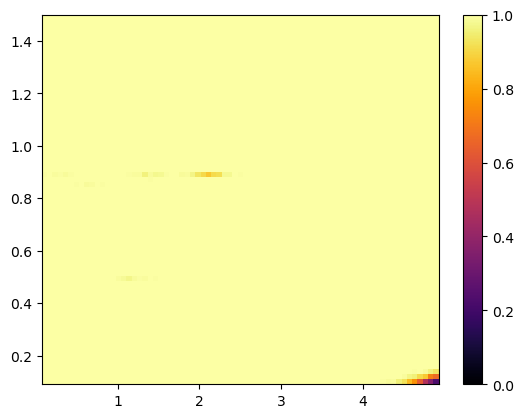

In [60]:
z = coverage_TRUST_plus.reshape(75,75)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, nu_v, z, vmin= np.min(coverage_TRUST),vmax=1,
                    cmap = "inferno")
fig.colorbar(pc)

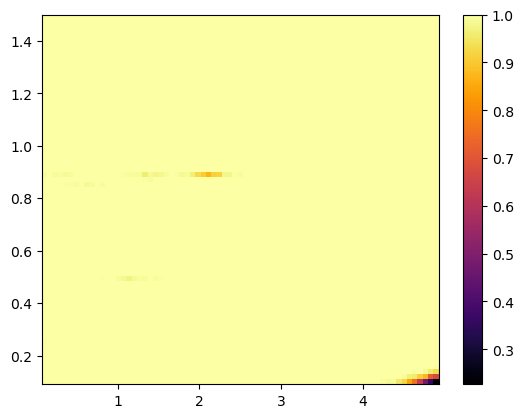

In [61]:
z = coverage_TRUST_plus.reshape(75, 75)
fig = plt.figure()
pc = plt.pcolormesh(mu_v, nu_v, z, vmin= np.min(coverage_TRUST_plus),vmax=1, cmap = "inferno")
fig.colorbar(pc)